In [9]:
from google.colab import files
files.upload() # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dakshvpatel","key":"253ce4ebab6dea3b84f9a2fdaa983b7d"}'}

In [10]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99% 1.02G/1.04G [00:07<00:00, 319MB/s]
100% 1.04G/1.04G [00:07<00:00, 155MB/s]


In [12]:
!unzip flickr8k.zip -d flickr8k_data

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k_data/Images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k_data/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k_data/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k_data/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k_data/Images/2846037553_1a1de50709.jpg  
  inflating: flickr8k_data/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k_data/Images/2846843520_b0e6211478.jpg  
  inflating: flickr8k_data/Images/2847514745_9a35493023.jpg  
  inflating: flickr8k_data/Images/2847615962_c330bded6e.jpg  
  inflating: flickr8k_data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k_data/Images/2848266893_9693c66275.jpg  
  inflating: flickr8k_data/Images/2848571082_26454cb981.jpg  
  inflating: flickr8k_data/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k_data/Images/2848977044_446a31d86e.jpg  
  inflating: flickr8k_data/Images/2849194983_2968c72832.jpg  
  inflating: flickr

In [13]:
import os

# Path to the extracted dataset
dataset_path = "/content/flickr8k_data"

# List files in the directory
os.listdir(dataset_path)


['Images', 'captions.txt']

### To load and display images:


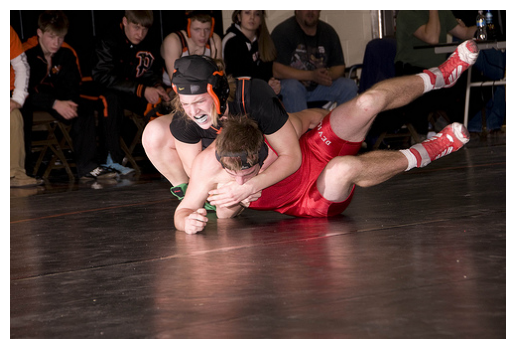

Image filename: 3205336477_037d4b6bd9.jpg


In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Path to the images folder
images_path = os.path.join(dataset_path, "Images")

# Get a random image
random_image = random.choice(os.listdir(images_path))

# Display the image
img = mpimg.imread(os.path.join(images_path, random_image))
plt.imshow(img)
plt.axis("off")
plt.show()

print("Image filename:", random_image)

####The captions.txt file contains image names and captions. Let's load it into a DataFrame:



In [15]:
import pandas as pd

# Load the captions file
captions_path = os.path.join(dataset_path, "captions.txt")

data = pd.read_csv(captions_path)
print(data.head())  # Show first few rows
data.columns

                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


Index(['image', 'caption'], dtype='object')

In [16]:
data.columns = ["filename", "caption"]

# Group by filenames to see multiple captions per image
image_captions = data.groupby("filename")["caption"].apply(list).reset_index()
print(image_captions.head())


                    filename  \
0  1000268201_693b08cb0e.jpg   
1  1001773457_577c3a7d70.jpg   
2  1002674143_1b742ab4b8.jpg   
3  1003163366_44323f5815.jpg   
4  1007129816_e794419615.jpg   

                                             caption  
0  [A child in a pink dress is climbing up a set ...  
1  [A black dog and a spotted dog are fighting, A...  
2  [A little girl covered in paint sits in front ...  
3  [A man lays on a bench while his dog sits by h...  
4  [A man in an orange hat starring at something ...  





# Imports Tools and Libraries




In [17]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm

# NLP imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical # OHE
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional

# Model creation import
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split

# Computer vision import
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer

# Model Learning and Losses Imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# warning and Viz
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import pickle

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

#Image Captioning
##What is Image Captioning ?


*   Image Captioning is the process of generating textual
description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
*   This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.






##CNNs + RNNs (LSTMs)


*   To perform Image Captioning we will require two deep learning models combined into one for the training purpose
*   CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction


*   LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word
*   For a more illustrative explanation of this architecture check the Modelling section for a picture representation


In [18]:
print(images_path)
data.head()


/content/flickr8k_data/Images


filename  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [19]:
import os
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))

    for i in range(min(15, len(temp_df))):
        plt.subplot(5, 5, i + 1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)

        image_path = f"/content/flickr8k_data/Images/{temp_df.filename[i]}"

        if not os.path.exists(image_path):  # Skip if file not found
            print(f"File not found: {image_path}")
            continue

        image = readImage(image_path)
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

    plt.show()


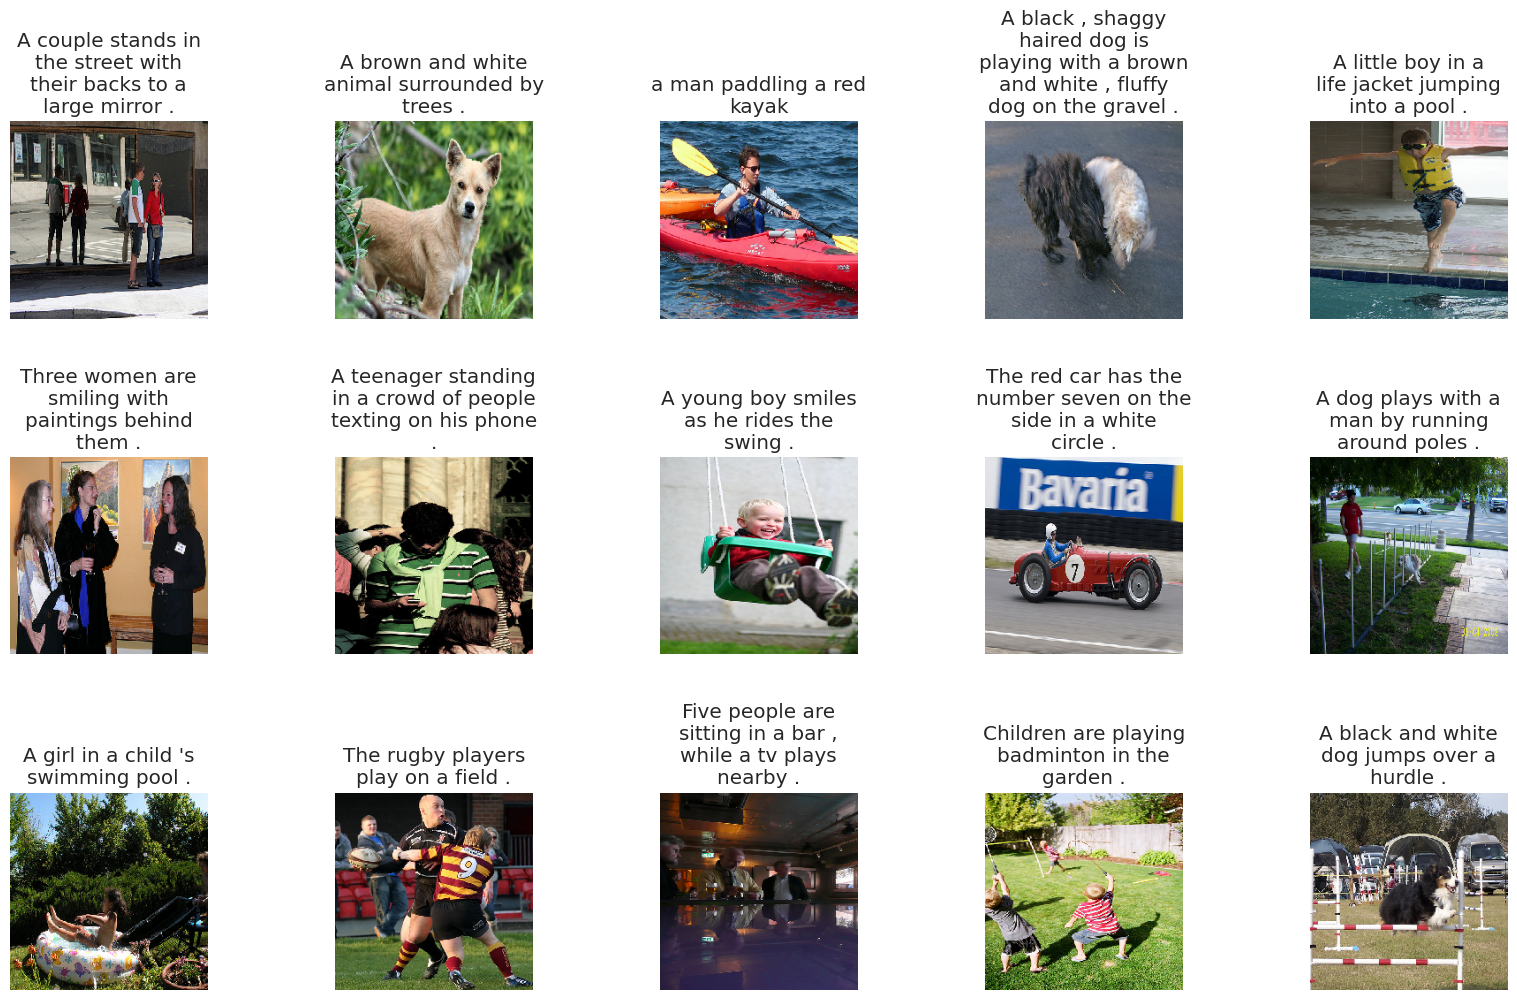

In [20]:
display_images(data.sample(15))

## Caption Text Preprocessing

1. Convert sentences into lowercase
2. Remove special characters and numbers present in the text
3. Remove extra spaces
4. Remove single characters
5. Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence




In [21]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions) # TO tokenize
vocab_size = len(tokenizer.word_index) + 1 # to find total no. of tokens in vocab
max_length = max(len(caption.split()) for caption in captions) # to find max_length caption

images = data['filename'].unique().tolist()
nimages = len(images) # total number of images---> 8091

## split images into train and validation images
"""split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]
"""
#from sklearn.model_selection import train_test_split
train_images, val_images = train_test_split(images, test_size=0.15, random_state=42)

train = data[data['filename'].isin(train_images)]
test = data[data['filename'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0] # to show tokenize value of caption

[1, 18, 315, 63, 195, 116, 2]

# Image Feature Extraction


*   DenseNet 201 Architecture is used to extract the features from the images
*   Any other pretrained architecture can also be used for extracting features from these images
*   Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

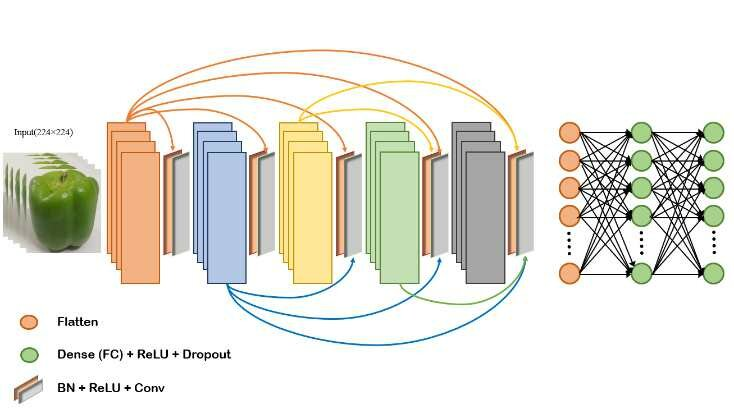






In [15]:

#Load Pretrained DenseNet201 (Optimized)
base_model = DenseNet201(weights="imagenet", include_top=False, pooling="avg")
fe = Model(inputs=base_model.input, outputs=base_model.output)

# Image Preprocessing Function
def process_image(image_path, img_size=224):
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # DenseNet201-specific preprocessing
    return img

# Extract Features for Each Image
features = {}
images_path = "/content/flickr8k_data/Images"

for image in tqdm(data['filename'].unique().tolist()):
    img_path = os.path.join(images_path, image)

    if not os.path.exists(img_path):  # Skip missing files
        print(f"File not found: {img_path}")
        continue

    img = process_image(img_path)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

# Save Features for Future Use
with open("image_features.pkl", "wb") as f:
    pickle.dump(features, f)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


100%|██████████| 8091/8091 [15:52<00:00,  8.49it/s]


In [16]:
df = pd.DataFrame(list(features.items()), columns=["Filename", "Feature"])
#print(df.head())  # Display first 5 rows
df.sample(1)["Feature"]

7254    [[8.553385e-05, 0.000525062, 0.00033862033, 0....
Name: Feature, dtype: object

In [17]:
# check shape of all features
feature_shapes = set(feature.shape for feature in features.values())  # Collect unique shapes

if len(feature_shapes) == 1:
    print(f"All features have the same shape: {feature_shapes.pop()}")
else:
    print(f"Different feature shapes found: {feature_shapes}")


All features have the same shape: (1, 1920)


# Data Generation
* Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
* The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
* The text embeddings are passed word by word for the caption generation during inference time

In [18]:
# make custom class
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy() #DataFrame containing image filenames and captions.
        self.X_col = X_col #Column name for image filenames.
        self.y_col = y_col #Column name for captions.
        self.directory = directory #Folder where images are stored (not used in this case).
        self.batch_size = batch_size #Number of samples per batch (e.g., 64).
        self.tokenizer = tokenizer #Converts text captions into numeric sequences.
        self.vocab_size = vocab_size #Number of unique words in the dataset.
        self.max_length = max_length #Maximum number of words per caption.
        self.features = features #A dictionary containing pre-extracted image features (from EfficientNet or DenseNet).
        self.shuffle = shuffle #Shuffles the data after each epoch.
        self.n = len(self.df)

    #Shuffles the dataset at the end of each epoch to improve training.
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    #Returns the total number of batches per epoch.
    def __len__(self):
        return self.n // self.batch_size

    #Selects a batch of images and captions based on the index.
    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y


'''Retrieves image features from the features dictionary.
Converts each caption into a sequence of numbers.
Generates (input, target) pairs where:
X1 = Image feature vector
X2 = Partial text sequence
y = Next word in the caption (one-hot encoded)
Converts everything into NumPy arrays for training.'''


train_generator = CustomDataGenerator(df=train,X_col='filename',y_col='caption',batch_size=64,directory=images_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='filename',y_col='caption',batch_size=64,directory=images_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [19]:
train_generator[0]
# It generates X1,X2,y
# X1: Images as a feature grid
# X2: Caption vectors with zero padding
# y: OHE(encoded form of caption)

((array([[8.4153093e-05, 5.7382416e-04, 1.0144024e-03, ..., 4.4887644e-01,
          1.5173389e-01, 1.1663284e+00],
         [8.4153093e-05, 5.7382416e-04, 1.0144024e-03, ..., 4.4887644e-01,
          1.5173389e-01, 1.1663284e+00],
         [8.4153093e-05, 5.7382416e-04, 1.0144024e-03, ..., 4.4887644e-01,
          1.5173389e-01, 1.1663284e+00],
         ...,
         [1.7417887e-04, 5.3456501e-04, 1.3675566e-03, ..., 0.0000000e+00,
          1.5397656e+00, 1.4775646e+00],
         [1.7417887e-04, 5.3456501e-04, 1.3675566e-03, ..., 0.0000000e+00,
          1.5397656e+00, 1.4775646e+00],
         [1.7417887e-04, 5.3456501e-04, 1.3675566e-03, ..., 0.0000000e+00,
          1.5397656e+00, 1.4775646e+00]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  42],
         [  0,   0,   0, ...,   1,  42,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         [  0,   0,   0, ...,

# Modelling
* The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network
* The LSTM network starts generating words after each input thus forming a sentence at the end

In [21]:
from tensorflow.keras.utils import plot_model # to plot architecture

input1 = Input(shape=(1920,)) # It represent extracted image features
input2 = Input(shape=(max_length,)) # Tokenize Text input

# Imput images feature of 256 length
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

# Input Text features of 256 length(each token is represented by 256 length data)
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)


# Concat Image+Text features
merged = concatenate([img_features_reshaped,sentence_features],axis=1)

# Layer Normalization after merging of Image + Text featues
merged = tf.keras.layers.LayerNormalization()(merged)

# this merged input feature is passed to the LSTM with 256 nerons
# sentence_features = LSTM(256)(merged)
sentence_features = Bidirectional(LSTM(256))(merged)
# Size of sentence_feature is 256 + 256 as Bidirectional LSTM

x = Dropout(0.3)(sentence_features)
img_features = Dense(512, activation='relu')(img_features) # Increase size of Img fettures to 512d
x = add([x, img_features]) # Residual connection

## FCL
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
## Output layer(No of Op nuerons = vocab_size(all uniqur words in vocab))
output = Dense(vocab_size, activation='softmax')(x) # multi class classification

# Modle compilation
caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint (to save best models)
model_name = "model.keras"  # Update the extension to .keras
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Early stop if Validation loss will not improve within 10 epochs
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights=True)

#Reduces learning rate when the model stops improving.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)




# Train model
history = caption_model.fit(
        train_generator, # In batches
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 5.2853
Epoch 1: val_loss improved from inf to 3.91696, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 99s 170ms/step - loss: 5.2841 - val_loss: 3.9170 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 3.8449
Epoch 2: val_loss improved from 3.91696 to 3.65126, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 87s 161ms/step - loss: 3.8448 - val_loss: 3.6513 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 3.5039
Epoch 3: val_loss improved from 3.65126 to 3.53030, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 88s 164ms/step - loss: 3.5039 - val_loss: 3.5303 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 3.2949
Epoch 4: val_loss improved from 3.53030 to 3.49103, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 87s 162ms/step - loss: 3.2949 - val_loss: 3.4910 - learning_rate: 0.0010


# Learning Curve
* The model has clearly overfit, possibly due to less amount of data
* We can tackle this problem in two ways
     1. Train the model on a larger dataset Flickr40k
     2. Attention Models

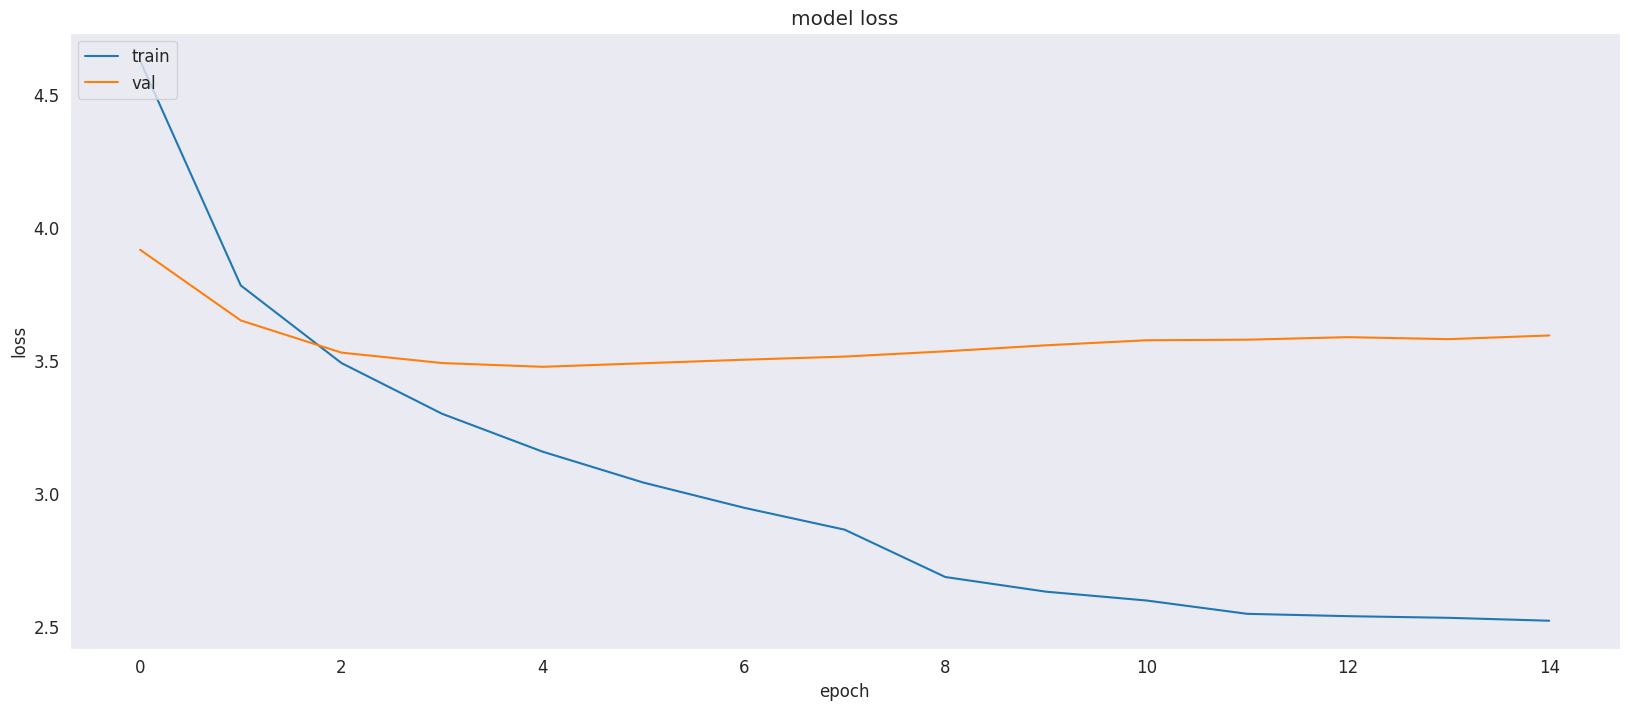

In [22]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Caption Generation Utility Functions
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [23]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor.keras")

In [24]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size)) #Loads the image and resizes it to (224, 224).
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0) #Expands dimensions to fit the model’s expected input shape ((1, 224, 224, 3)).
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features

    # Generate the caption
    in_text = "startseq" #Initializes the caption with "startseq".

    for i in range(max_length): #Iterates up to max_length times to generate words.
        #Converts words into tokenized sequences.
        sequence = tokenizer.texts_to_sequences([in_text])[0]

        #Pads the sequence to ensure fixed input size
        sequence = pad_sequences([sequence], maxlen=max_length)

        #Passes the extracted image features & tokenized sequence into the caption_model.
        #Gets probabilities for the next word and selects the word with the highest probability.
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)

        #Looks up the word corresponding to the predicted token.If no word is found, exit the loop
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break

        #Adds the predicted word to the existing text. Stops if "endseq" is generated.
        in_text += " " + word
        if word == "endseq":
            break

    #Removes "startseq" and "endseq" from the caption. Trims extra spaces
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

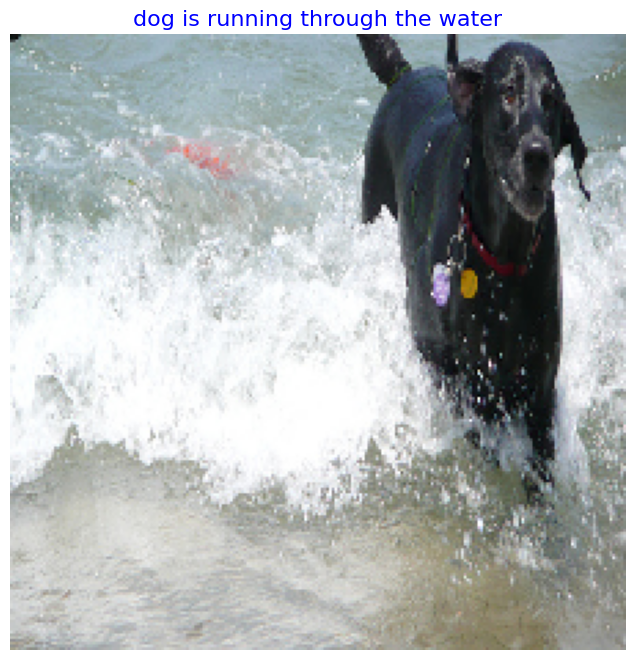

In [25]:
# Example usage
image_path = "/content/flickr8k_data/Images/1022975728_75515238d8.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

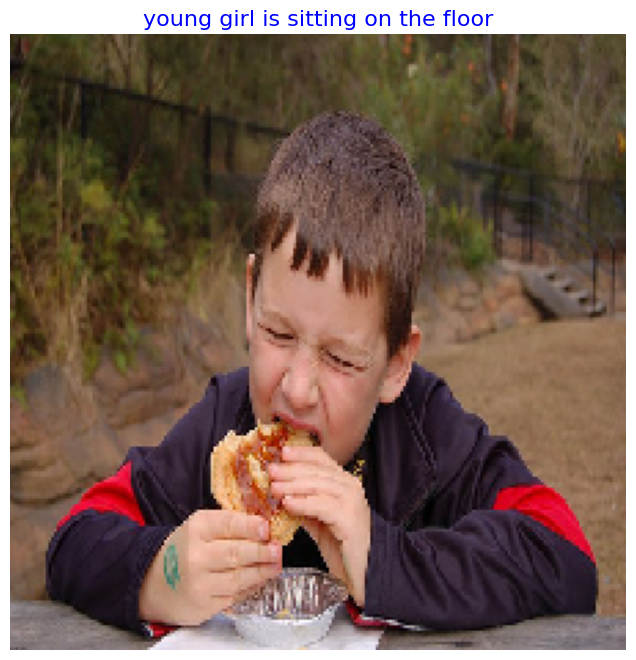

In [26]:

# Example usage
image_path = "/content/flickr8k_data/Images/1034276567_49bb87c51c.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

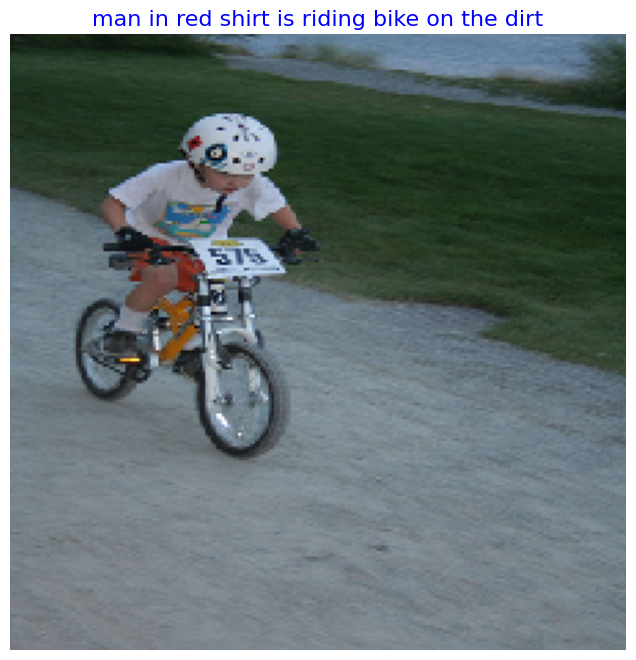

In [27]:

# Example usage
image_path = "/content/flickr8k_data/Images/1075716537_62105738b4.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

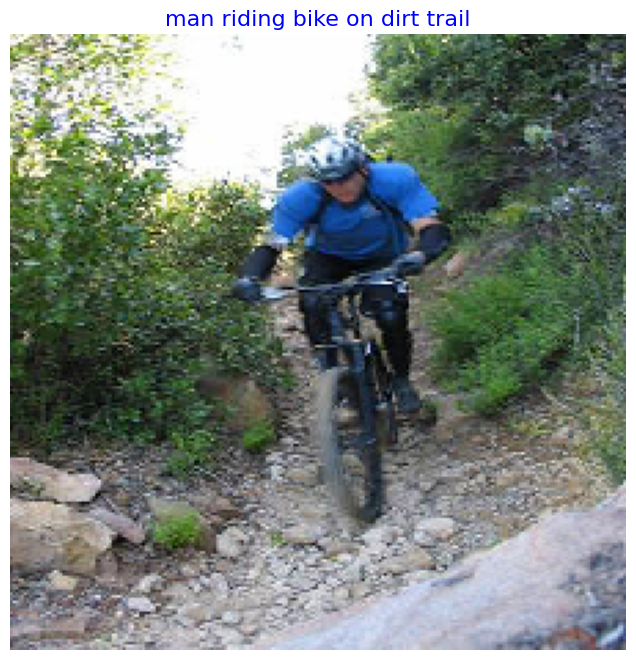

In [28]:
# Example usage
image_path = "/content/flickr8k_data/Images/124881487_36e668145d.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

## Model Evaluation

In [2]:
pip install "git+https://github.com/salaniz/pycocoevalcap.git"

  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-21wlobcl
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-21wlobcl
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=e24eb0cb7b30ff67a516b16ab12bf3693d419d09217a0e86836a907205426ef8
  Stored in directory: /tmp/pip-ephem-wheel-cache-rgzqz6h4/wheels/e5/d1/50/82763a91172a5c8058c9efff8692f3a41570e3ddd5b5b2c4b4
Successfully built pycocoevalcap


In [3]:
pip install rouge

In [ ]:
import os
import numpy as np
import pickle
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Paths for model files
model_path = "/content/model (1).keras"
tokenizer_path = "/content/tokenizer (1).pkl"
feature_extractor_path = "/content/feature_extractor (1).keras"

# Folder where images are stored
image_folder = "/content/flickr8k_data/Images/"  # Update this to your correct image directory

# Load trained models
caption_model = load_model(model_path)
feature_extractor = load_model(feature_extractor_path)

# Load tokenizer
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

# Function to generate captions for an image
def generate_caption(image_path, max_length=34, img_size=224):
    """Generates a caption for an image"""
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return ""

    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    # Extract image features
    image_features = feature_extractor.predict(img, verbose=0)

    in_text = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break

    return in_text.replace("startseq", "").replace("endseq", "").strip()

# Load test dataset (images and ground truth captions)
test_images = test['filename'].tolist()
test_images = [os.path.join(image_folder, img) for img in test_images]  # Add full path

reference_captions = test.groupby('filename')['caption'].apply(list).tolist()

# Generate captions for test images
generated_captions = [generate_caption(image) for image in test_images]

# BLEU Score Calculation
def evaluate_bleu(references, candidates):
    """Compute BLEU scores"""
    bleu1 = corpus_bleu(references, candidates, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25))
    return {"BLEU-1": bleu1, "BLEU-2": bleu2, "BLEU-3": bleu3, "BLEU-4": bleu4}

# ROUGE Score Calculation
def evaluate_rouge(references, candidates):
    """Compute ROUGE scores"""
    rouge = Rouge()
    scores = [rouge.get_scores(c, r)[0]["rouge-l"]["f"] for c, r in zip(candidates, references)]
    return {"ROUGE-L": np.mean(scores)}

# Compute BLEU and ROUGE metrics
bleu_scores = evaluate_bleu(reference_captions, generated_captions)
rouge_scores = evaluate_rouge(reference_captions, generated_captions)

# Print results
print("Performance Metrics for Image Captioning Model:")
for metric, value in {**bleu_scores, **rouge_scores}.items():
    print(f"{metric}: {value:.4f}")


In [39]:
print(test.columns)  # Check available columns in the DataFrame


Index(['filename', 'caption'], dtype='object')


In [41]:
image_folder = "/content/flickr8k_data/Images/"  # Update with the actual path
image_path = os.path.join(image_folder, "1022454428_b6b660a67b.jpg")

print("Full Path:", image_path)
print("File exists:", os.path.exists(image_path))


Full Path: /content/flickr8k_data/Images/1022454428_b6b660a67b.jpg
File exists: True
